In [ ]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from transformers import InformerConfig, InformerForPrediction
from one.api import ONE
from sklearn.model_selection import train_test_split

# --- Ensure custom utils are in the path ---
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from utils.load_meso_session import MesoscopeSession

print("STEP 1: Loading data from IBL...")

# --- Load the real session data ---
one = ONE()
SESSION_INDEX = 0
session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', SESSION_INDEX, True)
# Using a 1000s window as in your example. You can remove the time_window argument to use the full session.
activity_matrix, timestamps = session.get_activity_matrix(time_window=3000)

# --- Confirm data was loaded ---
print(f"Successfully loaded data. Activity matrix shape: {activity_matrix.shape}")


STEP 1: Loading data from IBL...


KeyboardInterrupt: 

In [ ]:

# ===================================================================
# Step 2: Robust, Per-Neuron Normalization
# ===================================================================
print("\nSTEP 2: Normalizing the activity matrix...")

activity_matrix_normalized = activity_matrix.copy()
lower_percentile = 0
upper_percentile = 99.5
min_vals = np.percentile(activity_matrix_normalized, lower_percentile, axis=0)
max_vals = np.percentile(activity_matrix_normalized, upper_percentile, axis=0)
epsilon = 1e-6
denominator = max_vals - min_vals
denominator[denominator < epsilon] = epsilon
activity_matrix_normalized = (activity_matrix_normalized - min_vals) / denominator
activity_matrix_normalized = np.clip(activity_matrix_normalized, 0, 1)

print("Normalization complete.")


# ===================================================================
# Step 3: Data Preparation (Windowing)
# ===================================================================
print("\nSTEP 3: Preparing data windows for the Transformer...")

# --- Define Model/Data Parameters ---
context_length = int(10 * 4.9)  # Use 10 seconds of history (49 samples)
prediction_length = int(2 * 4.9)  # Predict the next 2 seconds (~10 samples)
num_neurons = activity_matrix_normalized.shape[1]

# In Step 3, when you define the config:
config = InformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,
    input_size=num_neurons,
    num_time_features=1,
    
    d_model=128,         
    encoder_layers=4,  
    decoder_layers=4, 
    encoder_attention_heads=8,
    decoder_attention_heads=8,
    encoder_ffn_dim=256,
    decoder_ffn_dim=256,
)

# --- Create the sliding windows ---
max_lag = max(config.lags_sequence)
past_sequence_length = context_length + max_lag

past_values_list = []
future_values_list = []
past_time_features_list = []
future_time_features_list = []

# Create a normalized time feature (from 0 to 1)
time_feature = timestamps / timestamps.max()

# Loop through the normalized data to create windows
for i in range(len(activity_matrix_normalized) - past_sequence_length - prediction_length + 1):
    past_start_idx, past_end_idx = i, i + past_sequence_length
    future_start_idx, future_end_idx = past_end_idx, past_end_idx + prediction_length

    past_values_list.append(activity_matrix_normalized[past_start_idx:past_end_idx, :])
    future_values_list.append(activity_matrix_normalized[future_start_idx:future_end_idx, :])
    
    past_time_features_list.append(time_feature[past_start_idx:past_end_idx, np.newaxis])
    future_time_features_list.append(time_feature[future_start_idx:future_end_idx, np.newaxis])

# --- Convert lists to PyTorch Tensors ---
past_values = torch.from_numpy(np.array(past_values_list, dtype=np.float32))
future_values = torch.from_numpy(np.array(future_values_list, dtype=np.float32))
past_time_features = torch.from_numpy(np.array(past_time_features_list, dtype=np.float32))
future_time_features = torch.from_numpy(np.array(future_time_features_list, dtype=np.float32))
past_observed_mask = torch.ones_like(past_values)

print(f"Data prepared. Total samples: {len(past_values)}. Tensor shape: {past_values.shape}")




STEP 2: Normalizing the activity matrix...
Normalization complete.

STEP 3: Preparing data windows for the Transformer...


: 

In [ ]:


# ===================================================================
# Step 4: Split Data and Set Up DataLoaders
# ===================================================================
print("\nSTEP 4: Splitting data and setting up DataLoaders...")

# --- Create a list of indices to split ---
# This ensures all tensors are split consistently.
num_samples = len(past_values)
indices = list(range(num_samples))

# --- Split indices into training and validation sets (90/10 split) ---
train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=42, shuffle=True)

# --- Create Training Datasets and DataLoader ---
train_dataset = TensorDataset(
    past_values[train_indices],
    past_time_features[train_indices],
    future_values[train_indices],
    future_time_features[train_indices],
    past_observed_mask[train_indices]
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# --- Create Validation Datasets and DataLoader ---
val_dataset = TensorDataset(
    past_values[val_indices],
    past_time_features[val_indices],
    future_values[val_indices],
    future_time_features[val_indices],
    past_observed_mask[val_indices]
)
# No need to shuffle the validation loader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Data split: {len(train_indices)} training samples, {len(val_indices)} validation samples.")

# --- Setup Model and Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InformerForPrediction(config)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# --- Hyperparameters for the new training regime ---
# We still keep scale regularization as a safety measure.
SCALE_REG_WEIGHT = 0.05 

# ===================================================================
# Step 5: Training & Validation Loop for Continuous Data
# ===================================================================
print("\nSTEP 5: Starting Training & Validation Loop for Continuous Data...")
epochs = 20

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    for i, batch in enumerate(train_loader):
        p_vals, p_time, f_vals, f_time, p_obs_mask = [b.to(device) for b in batch]
        optimizer.zero_grad()
        
        # --- 1. Get the model's own calculated loss ---
        # We can use the model's forward pass directly now. It calculates the NLL internally.
        outputs = model(
            past_values=p_vals,
            past_time_features=p_time,
            past_observed_mask=p_obs_mask,
            future_values=f_vals,
            future_time_features=f_time,
            return_dict=True,
        )
        nll_loss = outputs.loss

        # --- 2. Calculate the Scale Regularization Loss ---
        # We need to manually get the distribution to access the scale parameter.
        # This requires one extra forward pass on the base model, but it's worth it for stability.
        with torch.no_grad(): # We don't need gradients for this part of the calculation
            base_model_outputs = model.model(
                past_values=p_vals, past_time_features=p_time, past_observed_mask=p_obs_mask,
                future_values=f_vals, future_time_features=f_time, return_dict=True
            )
        params = model.parameter_projection(base_model_outputs.last_hidden_state)
        distribution = model.output_distribution(params, loc=base_model_outputs.loc, scale=base_model_outputs.scale)
        scale = distribution.scale + 1e-8
        scale_reg_loss = torch.mean(-torch.log(scale))
        
        # --- 3. Combine the two loss terms ---
        loss = nll_loss + (SCALE_REG_WEIGHT * scale_reg_loss)
        
        # --- Backpropagation on the combined loss ---
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            p_vals, p_time, f_vals, f_time, p_obs_mask = [b.to(device) for b in batch]
            
            # Get the standard, un-weighted validation loss
            outputs = model(
                past_values=p_vals, past_time_features=p_time, past_observed_mask=p_obs_mask,
                future_values=f_vals, future_time_features=f_time, return_dict=True
            )
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # --- Print Epoch Results ---
    print(f"--- End of Epoch {epoch+1}/{epochs} ---")
    print(f"  Average Training Loss (NLL + Scale Pen): {avg_train_loss:.4f}")
    print(f"  Average Validation Loss (NLL): {avg_val_loss:.4f}")

print("\n--- Training Complete ---")

# --- Save the trained model for future inference ---
output_dir = "./informer_calcium_model_continuous"
model.save_pretrained(output_dir)
print(f"Model saved to '{output_dir}'")


STEP 4: Splitting data and setting up DataLoaders...
Data split: 4329 training samples, 481 validation samples.

STEP 5: Starting Training & Validation Loop for Continuous Data...
--- End of Epoch 1/20 ---
  Average Training Loss (NLL + Scale Pen): -197.2094
  Average Validation Loss (NLL): -3639.3110
--- End of Epoch 2/20 ---
  Average Training Loss (NLL + Scale Pen): -4286.3947
  Average Validation Loss (NLL): -4653.9159
--- End of Epoch 3/20 ---
  Average Training Loss (NLL + Scale Pen): -4769.6680
  Average Validation Loss (NLL): -4882.7454
--- End of Epoch 4/20 ---
  Average Training Loss (NLL + Scale Pen): -4908.5750
  Average Validation Loss (NLL): -4379.8457
--- End of Epoch 5/20 ---
  Average Training Loss (NLL + Scale Pen): -4960.7694
  Average Validation Loss (NLL): -5028.6746
--- End of Epoch 6/20 ---
  Average Training Loss (NLL + Scale Pen): -4991.3470
  Average Validation Loss (NLL): -5031.6471
--- End of Epoch 7/20 ---
  Average Training Loss (NLL + Scale Pen): -5035.7

STEP 1: Loading trained model...
The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Model loaded and set to evaluation mode.

STEP 2: Preparing a sample and generating forecast...
Forecast generated successfully.

STEP 3: Performing population-level evaluation...
Selected a subset of 100 neurons with highest future variance for analysis.

Sparsity (GT vs. Forecast): 0.00 vs. 0.00
Mean Activity (GT vs. Forecast): 0.5316 vs. 0.3760
Mean Correlation across 100 neurons: -0.090


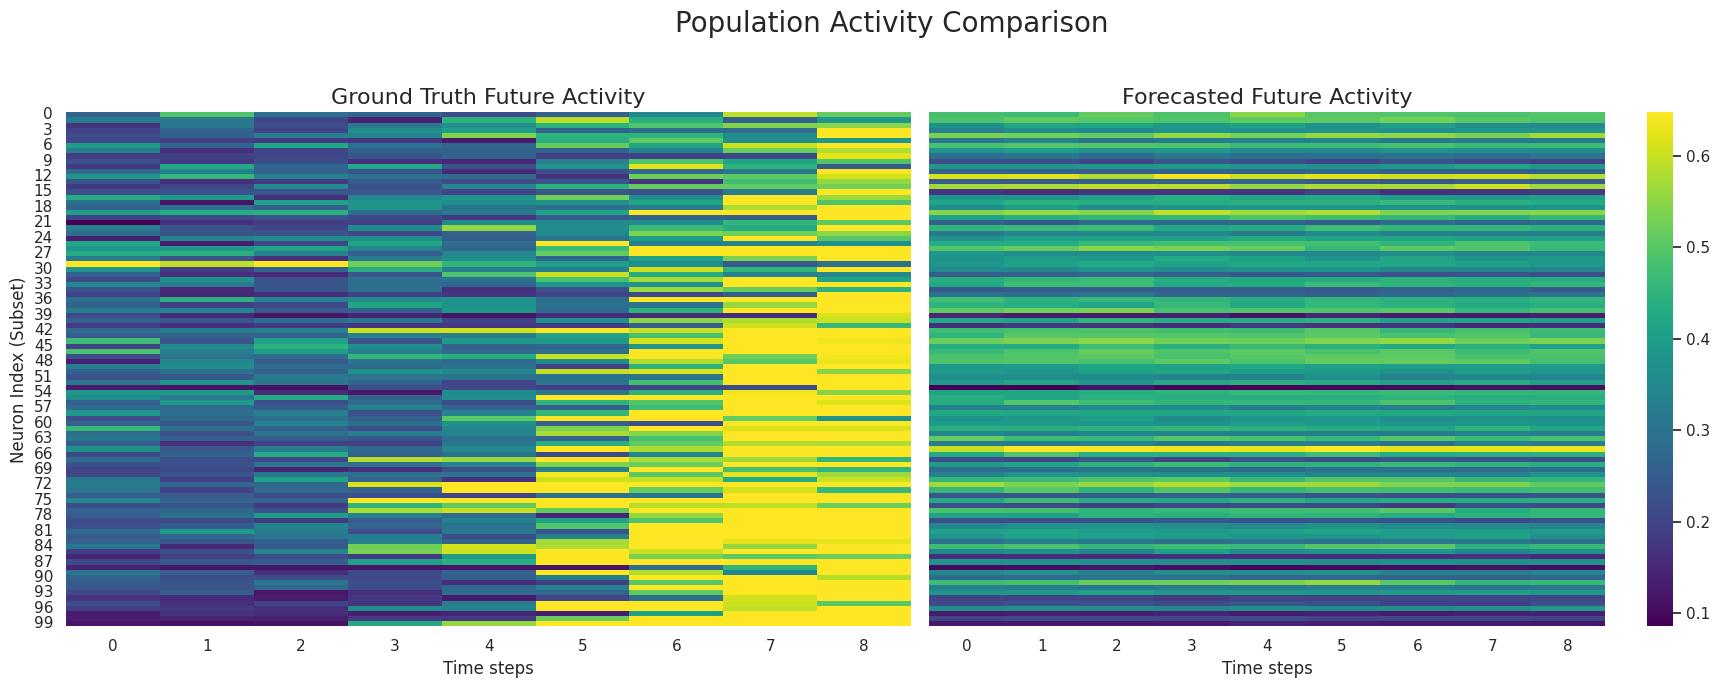

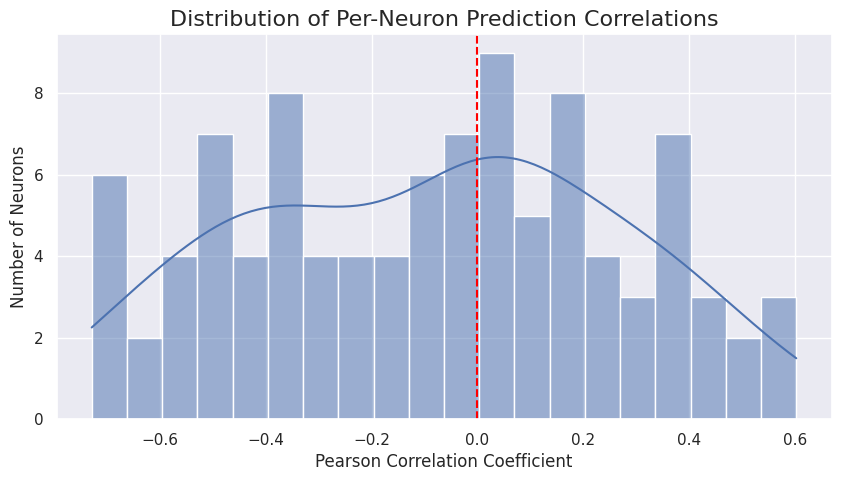

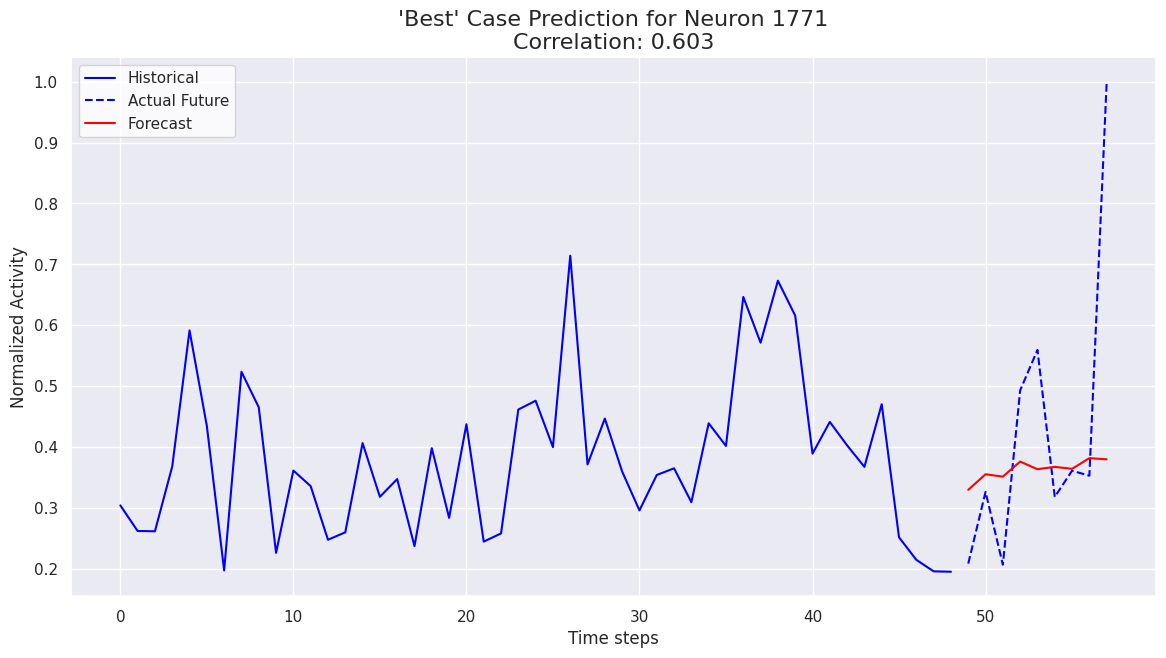

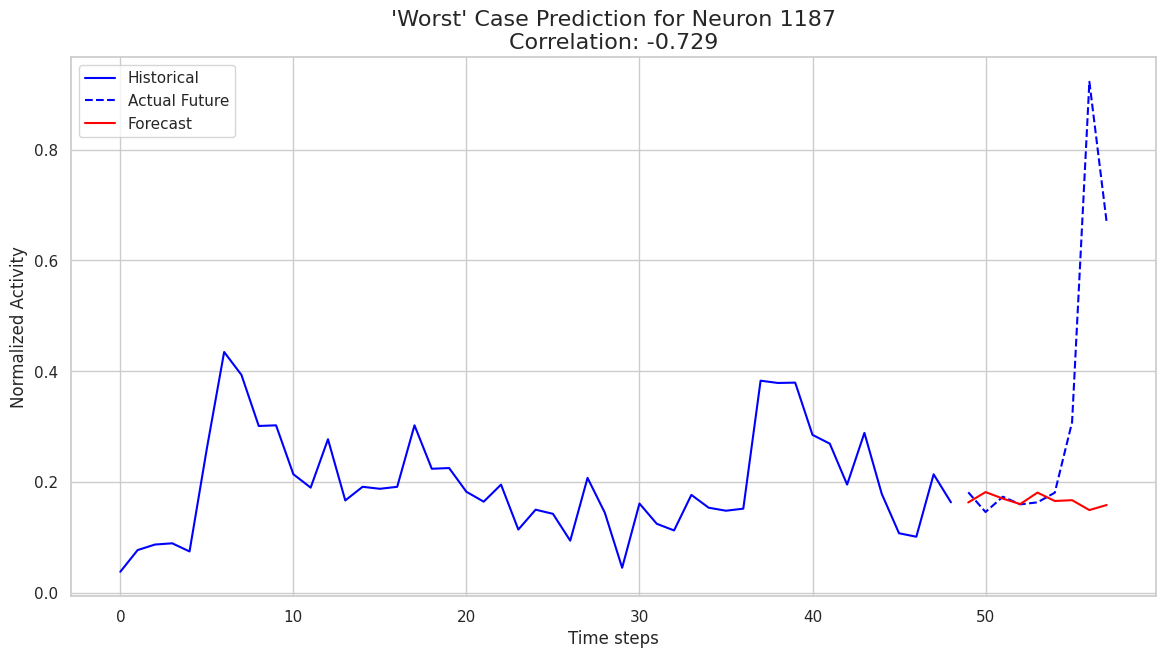

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import InformerForPrediction
from scipy.stats import pearsonr

# ===================================================================
# Step 1: Load Model & Set to Evaluation Mode (No Changes)
# ===================================================================
print("STEP 1: Loading trained model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "./informer_calcium_model"
model = InformerForPrediction.from_pretrained(output_dir)
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode.")


# ===================================================================
# Step 2: Select a Sample & Generate Forecast (No Changes)
# ===================================================================
print("\nSTEP 2: Preparing a sample and generating forecast...")
# Let's pick a sample from the original validation set for an honest evaluation
# If you don't have val_indices, you can just pick a random number like 500
try:
    sample_idx = val_indices[25] # Pick a sample from the validation set
except NameError:
    print("val_indices not found, picking a static sample_idx=500 instead.")
    sample_idx = 500

past_val_sample_for_input = past_values[sample_idx]
future_time_sample_for_input = future_time_features[sample_idx]

inference_input = {
    "past_values": past_val_sample_for_input.unsqueeze(0).to(device),
    "past_time_features": past_time_features[sample_idx].unsqueeze(0).to(device),
    "future_time_features": future_time_sample_for_input.unsqueeze(0).to(device)
}
with torch.no_grad():
    outputs = model.generate(**inference_input)
# Move to CPU and remove extra dims for analysis
forecast_sequences = outputs.sequences.mean(dim=1).cpu().squeeze().numpy()
print("Forecast generated successfully.")


# ===================================================================
# Step 3: A More Thorough, Population-Based Evaluation
# ===================================================================
print("\nSTEP 3: Performing population-level evaluation...")

# --- A. Select a Neuron Subset ---
# Let's select the 100 neurons with the most variance in the future window
# This gives us an interesting, active population to analyze.
start_slice = sample_idx
end_slice = sample_idx + past_sequence_length + prediction_length
ground_truth_window = activity_matrix_normalized[start_slice:end_slice, :]
ground_truth_future = ground_truth_window[-prediction_length:]

future_variances = np.var(ground_truth_future, axis=0)
top_100_indices = np.argsort(future_variances)[-100:] # Get indices of top 100

# Slice the data to focus only on this subset
ground_truth_subset = ground_truth_future[:, top_100_indices]
forecast_subset = forecast_sequences[:, top_100_indices]

print(f"Selected a subset of 100 neurons with highest future variance for analysis.")

# --- B. Calculate Population Metrics ---
# Sparsity: What percentage of values are near zero?
gt_sparsity = np.mean(ground_truth_subset < 0.01)
fc_sparsity = np.mean(forecast_subset < 0.01)
print(f"\nSparsity (GT vs. Forecast): {gt_sparsity:.2f} vs. {fc_sparsity:.2f}")

# Mean Activity Level
gt_mean_activity = np.mean(ground_truth_subset)
fc_mean_activity = np.mean(forecast_subset)
print(f"Mean Activity (GT vs. Forecast): {gt_mean_activity:.4f} vs. {fc_mean_activity:.4f}")

# Correlation: How well does the forecast for each neuron track the ground truth?
correlations = []
for i in range(ground_truth_subset.shape[1]):
    # Use pearsonr; it returns (correlation, p-value)
    corr, _ = pearsonr(ground_truth_subset[:, i], forecast_subset[:, i])
    correlations.append(corr)
correlations = np.nan_to_num(correlations) # Replace NaNs (from flat lines) with 0
print(f"Mean Correlation across {len(top_100_indices)} neurons: {np.mean(correlations):.3f}")

# --- C. Population Raster Plots ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
sns.set_theme(style="darkgrid")

# Ground Truth Raster
sns.heatmap(ground_truth_subset.T, cmap="viridis", ax=axes[0], cbar=False)
axes[0].set_title("Ground Truth Future Activity", fontsize=16)
axes[0].set_xlabel("Time steps")
axes[0].set_ylabel("Neuron Index (Subset)")

# Forecast Raster
sns.heatmap(forecast_subset.T, cmap="viridis", ax=axes[1])
axes[1].set_title("Forecasted Future Activity", fontsize=16)
axes[1].set_xlabel("Time steps")
axes[1].set_ylabel("") # Remove redundant label

fig.suptitle("Population Activity Comparison", fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- D. Histogram of Correlations ---
plt.figure(figsize=(10, 5))
sns.histplot(correlations, bins=20, kde=True)
plt.title("Distribution of Per-Neuron Prediction Correlations", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Number of Neurons")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# --- E. Plot Best and Worst Predicted Neurons ---
best_idx_in_subset = np.argmax(correlations)
worst_idx_in_subset = np.argmin(correlations)

# Map back to original neuron index
best_neuron_original_idx = top_100_indices[best_idx_in_subset]
worst_neuron_original_idx = top_100_indices[worst_idx_in_subset]

# Create plots for best and worst cases
for case, neuron_idx_in_subset, original_idx, corr_val in [
    ("Best", best_idx_in_subset, best_neuron_original_idx, np.max(correlations)),
    ("Worst", worst_idx_in_subset, worst_neuron_original_idx, np.min(correlations))
]:
    historical_activity = ground_truth_window[:-prediction_length, original_idx][-context_length:]
    actual_future_activity = ground_truth_subset[:, neuron_idx_in_subset]
    forecast_activity = forecast_subset[:, neuron_idx_in_subset]
    
    fig_case, ax_case = plt.subplots(figsize=(14, 7))
    sns.set_theme(style="whitegrid")
    
    sns.lineplot(x=np.arange(context_length), y=historical_activity, ax=ax_case, color="blue", label="Historical")
    sns.lineplot(x=np.arange(context_length, context_length + prediction_length), y=actual_future_activity, ax=ax_case, color="blue", linestyle="--", label="Actual Future")
    sns.lineplot(x=np.arange(context_length, context_length + prediction_length), y=forecast_activity, ax=ax_case, color="red", label="Forecast")
    
    title = (f"'{case}' Case Prediction for Neuron {original_idx}\n"
             f"Correlation: {corr_val:.3f}")
    ax_case.set_title(title, fontsize=16)
    ax_case.set_xlabel("Time steps")
    ax_case.set_ylabel("Normalized Activity")
    ax_case.legend()
    plt.show()

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import InformerForPrediction

# ===================================================================
# Step 1: Load Model & Set to Evaluation Mode (No Changes)
# ===================================================================
print("STEP 1: Loading trained model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "./informer_calcium_model"
model = InformerForPrediction.from_pretrained(output_dir)
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode.")


# ===================================================================
# Step 2: Select a Sample & Generate Forecast (No Changes)
# ===================================================================
print("\nSTEP 2: Preparing a sample and generating forecast...")
sample_idx = 500
# We still use past_values to generate the forecast, as this is what the model was trained on.
past_val_sample_for_input = past_values[sample_idx]
future_time_sample_for_input = future_time_features[sample_idx]

inference_input = {
    "past_values": past_val_sample_for_input.unsqueeze(0).to(device),
    "past_time_features": past_time_features[sample_idx].unsqueeze(0).to(device), # Also get the correct time features
    "future_time_features": future_time_sample_for_input.unsqueeze(0).to(device)
}
with torch.no_grad():
    outputs = model.generate(**inference_input)
forecast_sequences = outputs.sequences.mean(dim=1)
print("Forecast generated successfully.")


# ===================================================================
# Step 3: Calculate Performance Metrics & Plot
# ===================================================================
print("\nSTEP 3: Slicing ground truth data and calculating metrics...")

# --- THE FIX: Re-slice the ground truth from the definitive source ---
# This guarantees alignment between the normalized and unnormalized plots.
start_slice = sample_idx
end_slice = sample_idx + past_sequence_length + prediction_length

# Slice the window from the NORMALIZED matrix for the top plot
normalized_window = activity_matrix_normalized[start_slice:end_slice, :]
# Slice the window from the ORIGINAL matrix for the bottom plot
original_window = activity_matrix[start_slice:end_slice, :]

# --- Find an interesting neuron from the CORRECT future data slice ---
# We look for activity in the last `prediction_length` steps of the window.
neuron_to_plot = np.argmax(np.sum(normalized_window[-prediction_length:, :], axis=0))
print(f"Analyzing a specifically active neuron: Neuron {neuron_to_plot}")


# ===================================================================
# Step 4: Plot 1 - Normalized Prediction vs. CORRECT Ground Truth
# ===================================================================
print("\nSTEP 4: Plotting the normalized results...")

# --- Extract data for the chosen neuron from our new, correct slices ---
historical_activity = normalized_window[:-prediction_length, neuron_to_plot][-context_length:]
actual_future_activity = normalized_window[-prediction_length:, neuron_to_plot]
forecast_activity = forecast_sequences.squeeze().cpu().numpy()[:, neuron_to_plot]
print(f"Forecast activity {np.round(forecast_activity,4)}")
print(f"Actual future {np.round(actual_future_activity,4)}")


# --- Calculate metrics using the CORRECT ground truth ---
mae_single_neuron = F.l1_loss(torch.from_numpy(forecast_activity), torch.from_numpy(actual_future_activity)).item()
mse_single_neuron = F.mse_loss(torch.from_numpy(forecast_activity), torch.from_numpy(actual_future_activity)).item()

# --- Plotting ---
historical_time = np.arange(context_length)
future_time = np.arange(context_length, context_length + prediction_length)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))

sns.lineplot(x=historical_time, y=historical_activity, ax=ax, color="blue", label="Historical", linewidth=2)
sns.lineplot(x=future_time, y=actual_future_activity, ax=ax, color="blue", linestyle="--", label="Actual Future", linewidth=2)
sns.lineplot(x=future_time, y=forecast_activity, ax=ax, color="red", label="Forecast", linewidth=2)
ax.axvline(x=context_length - 0.5, color='gray', linestyle='--', linewidth=1.5)

title = (f"Normalized Prediction for Neuron {neuron_to_plot}\n"
         f"MAE: {mae_single_neuron:.4f} | MSE: {mse_single_neuron:.4f}")
ax.set_title(title, fontsize=16)
ax.set_xlabel("Time steps")
ax.set_ylabel("Normalized Activity")
ax.legend(loc="upper left")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# ===================================================================
# Step 5: Plot 2 - Original Unnormalized Signal (Now Correctly Aligned)
# ===================================================================
print("\nSTEP 5: Plotting the original, unnormalized signal for context...")

# --- Extract from the original_window we sliced earlier ---
original_historical = original_window[:-prediction_length, neuron_to_plot][-context_length:]
original_future = original_window[-prediction_length:, neuron_to_plot]

# --- Plotting ---
fig2, ax2 = plt.subplots(figsize=(14, 7))
sns.lineplot(x=historical_time, y=original_historical, ax=ax2, color="darkgreen", label="Historical Signal", linewidth=2)
sns.lineplot(x=future_time, y=original_future, ax=ax2, color="darkgreen", linestyle="--", label="Future Signal", linewidth=2)
ax2.axvline(x=context_length - 0.5, color='gray', linestyle='--', linewidth=1.5)
ax2.set_title(f"Original Unnormalized Signal for Neuron {neuron_to_plot}", fontsize=16)
ax2.set_xlabel("Time steps")
ax2.set_ylabel("Original Deconvolved Activity")
ax2.legend(loc="upper left")
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

STEP 1: Loading trained model...
Model loaded and set to evaluation mode.

STEP 2: Preparing a sample and generating forecast...


NameError: name 'past_values' is not defined